In [1]:
using Pkg
pkg"activate ."
pkg"instantiate"

 Activating environment at `~/Documents/otimizacao-em-julia/notebooks/Project.toml`


In [4]:
using Plots, Interact, LinearAlgebra, ForwardDiff
gr(size=(600,400))

Plots.GRBackend()

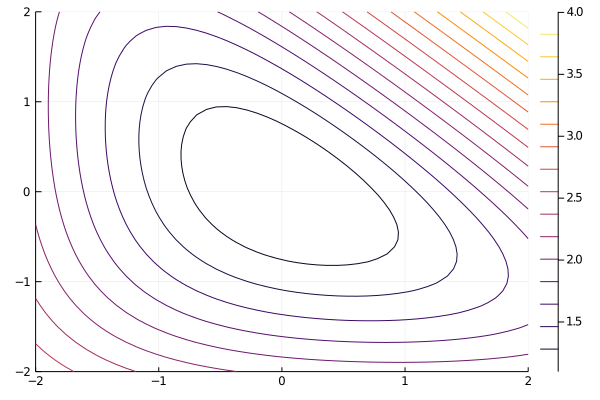

In [3]:
xg = range(-2, 2, length=50)
yg = copy(xg)

f(x) = log(exp(-x[1]) + exp(-x[2]) + exp(x[1] + x[2]))
contour(xg, yg, (x,y) -> f([x;y]))

In [8]:
function dfpB(B, s, y)
    ρ = 1 / dot(s, y)
    B = (I - ρ * y * s') * B * (I - ρ * s * y') + ρ * y * y'
    return B
end

function dfpH(H, s, y)
    H = H - (H * y) * (H * y)' / dot(y, H * y) + s * s' / dot(y, s)
    return H
end

function bfgsB(B, s, y)
    B = B - (B * s) * (B * s)' / dot(s, B * s) + y * y' / dot(y, s)
    return B
end

function bfgsH(H, s, y)
    ρ = 1 / dot(s, y)
    H = (I - ρ * s * y') * H * (I - ρ * y * s') + ρ * s * s'    
    return H
end

bfgsH (generic function with 1 method)

In [9]:
f(x) = (x[1] - 1)^2 + 4 * (x[2] - 2)^2
∇f(x) = ForwardDiff.gradient(f, x)
H(x) = ForwardDiff.hessian(f, x)

H (generic function with 1 method)

In [10]:
using Random
Random.seed!(0)
x = rand(2)
∇f(x)

2-element Array{Float64,1}:
 -0.35270498404517525
 -8.717147696588508

In [11]:
H(x)

2×2 Array{Float64,2}:
 2.0  0.0
 0.0  8.0

In [40]:
s = -∇f(x)
s = dot(s, s) / dot(s, H(x) * s) * s # pode substituir por busca exata
y = ∇f(x + s) - ∇f(x)
# Gradientes conjugados (roubando)
s2 = [1.0; 2.0] - (x + s)
y2 = ∇f(x + s + s2) - ∇f(x + s)
dot(s, y), dot(s2, y2)

(9.525809985495956, 0.0349734129064867)

In [42]:
∇f(x + s + s2)

2-element Array{Float64,1}:
 0.0
 0.0

In [43]:
Bx = Matrix(1.0I, 2, 2)
Hx = Matrix(1.0I, 2, 2)

2×2 Array{Float64,2}:
 1.0  0.0
 0.0  1.0

In [44]:
dfpB(Bx, s, y)

2×2 Array{Float64,2}:
 1.0001     0.0404569
 0.0404569  7.99836

In [45]:
dfpB(dfpB(Bx, s, y), s2, y2)

2×2 Array{Float64,2}:
  2.0          -2.77556e-17
 -4.16334e-17   8.0

In [46]:
x + s

2-element Array{Float64,1}:
 0.8677897412340612
 2.001337341606214

In [47]:
H(x + s)

2×2 Array{Float64,2}:
 2.0  0.0
 0.0  8.0

In [48]:
bfgsB(Bx, s, y)

2×2 Array{Float64,2}:
 0.999184   0.0404941
 0.0404941  7.99836

In [49]:
bfgsB(bfgsB(Bx, s, y), s2, y2)

2×2 Array{Float64,2}:
  2.0          -2.77556e-17
 -2.77556e-17   8.0

In [51]:
inv(H(x))

2×2 Array{Float64,2}:
 0.5  0.0
 0.0  0.125

In [50]:
dfpH(Hx, s, y)

2×2 Array{Float64,2}:
  1.0001      -0.00505867
 -0.00505867   0.125051

In [52]:
dfpH(dfpH(Hx, s, y), s2, y2)

2×2 Array{Float64,2}:
 0.5          2.60209e-18
 2.60209e-18  0.125

In [53]:
bfgsH(Hx, s, y)

2×2 Array{Float64,2}:
  1.00102     -0.00506797
 -0.00506797   0.125051

In [54]:
bfgsH(bfgsH(Hx, s, y), s2, y2)

2×2 Array{Float64,2}:
 0.5  0.0
 0.0  0.125

In [55]:
function bfgs(f, x)
    ∇f(x) = ForwardDiff.gradient(f, x)
    η = 1e-2
    num_backtrack = 0
    n = length(x)
    Hx = Matrix(1.0I, n, n)
    
    iter = 0
    while norm(∇f(x)) > 1e-4
        d = -Hx * ∇f(x)
        
        # Armijo
        α = 1.0
        while f(x + α * d) ≥ f(x) + η * α * dot(d, ∇f(x))
            α = α / 2
            num_backtrack = num_backtrack + 1
            if α < 1e-8
                error("Erro no backtracking")
            end
        end
        xt = x + α * d
        s = α * d
        y = ∇f(xt) - ∇f(x)
        x = xt
        
        if dot(s, y) ≤ 0
            @warn("sᵀy = $(dot(s,y))")
        else
            Hx = bfgsH(Hx, s, y)
        end
        
        iter += 1
        if iter > 1000
            error("Nao converge")
        end
    end
    
    return x, iter, num_backtrack
end

bfgs (generic function with 1 method)

In [84]:
function dfp_plot(p, f, x)
    ∇f(x) = ForwardDiff.gradient(f, x)
    η = 1e-2
    num_backtrack = 0
    n = length(x)
    Hx = Matrix(1.0I, n, n)
    
    scatter!(p, [x[1]], [x[2]], c=:magenta, ms=3)
    iter = 0
    while norm(∇f(x)) > 1e-4
        d = -Hx * ∇f(x)
        
        # Armijo
        α = 1.0
        while f(x + α * d) ≥ f(x) + η * α * dot(d, ∇f(x))
            α = α / 2
            num_backtrack = num_backtrack + 1
            if α < 1e-8
                error("Erro no backtracking")
            end
        end
        xt = x + α * d
        s = α * d
        y = ∇f(xt) - ∇f(x)
        plot!(p, [x[1], xt[1]], [x[2], xt[2]], c=:magenta, l=:arrow)
        x = xt
        scatter!(p, [x[1]], [x[2]], c=:magenta, ms=2)
        
        if dot(s, y) ≤ 0
            @warn("sᵀy = $(dot(s,y))")
        else
            Hx = dfpH(Hx, s, y)
        end
        
        iter += 1
        if iter > 1000
            error("Nao converge")
        end
    end
    
    return x, iter, num_backtrack
end

dfp_plot (generic function with 1 method)

In [99]:
function bfgs_plot(p, f, x)
    ∇f(x) = ForwardDiff.gradient(f, x)
    η = 1e-2
    num_backtrack = 0
    n = length(x)
    Hx = Matrix(1.0I, n, n)
    
    scatter!(p, [x[1]], [x[2]], c=:blue, ms=3)
    iter = 0
    while norm(∇f(x)) > 1e-4
        d = -Hx * ∇f(x)
        
        # Armijo
        α = 1.0
        while f(x + α * d) ≥ f(x) + η * α * dot(d, ∇f(x))
            α = α / 2
            num_backtrack = num_backtrack + 1
            if α < 1e-8
                error("Erro no backtracking")
            end
        end
        xt = x + α * d
        s = α * d
        y = ∇f(xt) - ∇f(x)
        plot!(p, [x[1], xt[1]], [x[2], xt[2]], c=:blue, l=:arrow)
        x = xt
        scatter!(p, [x[1]], [x[2]], c=:blue, ms=2)
        
        if dot(s, y) ≤ 0
            println("sᵀy = $(dot(s,y))")
        else
            Hx = bfgsH(Hx, s, y)
        end
        
        iter += 1
        if iter > 1000
            error("Nao converge")
        end
    end
    
    return x, iter, num_backtrack
end

bfgs_plot (generic function with 1 method)

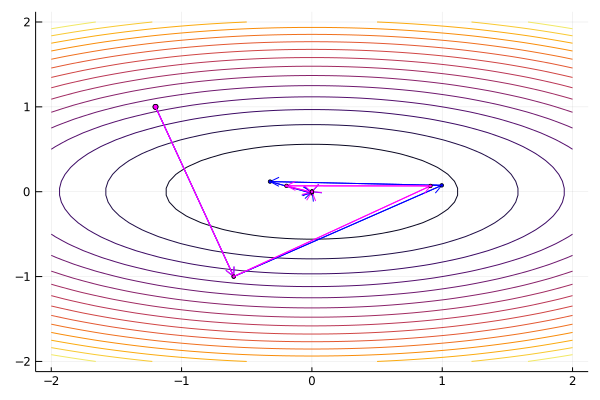

In [100]:
f(x) = x[1]^2 + 4 * x[2]^2
p = contour(xg, yg, (x,y) -> f([x;y]), leg=false)
bfgs_plot(p, f, [-1.2; 1.0])
dfp_plot(p, f, [-1.2; 1.0])
p

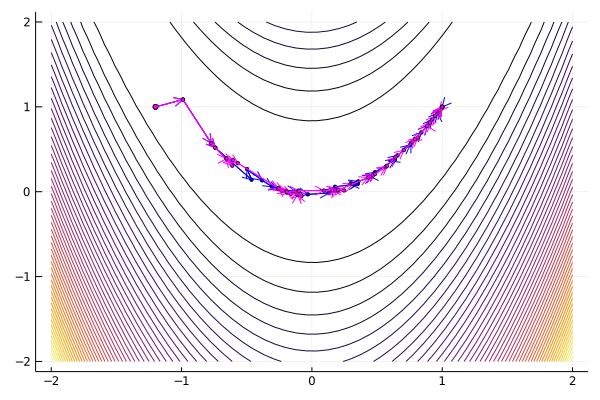

In [101]:
f(x) = (x[1] - 1)^2 + 100 * (x[2] - x[1]^2)^2
p = contour(xg, yg, (x,y) -> f([x;y]), leg=false, levels=50)
bfgs_plot(p, f, [-1.2; 1.0])
dfp_plot(p, f, [-1.2; 1.0])

p

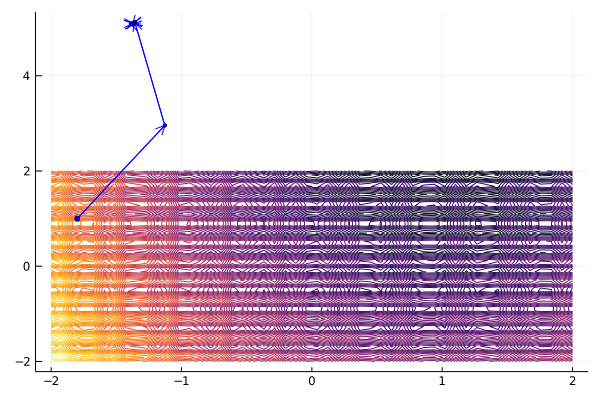

In [149]:
# f(x) = log(exp(-x[1]) + exp(-x[2]) + exp(x[1] + x[2]))
f(x) = ((x[1] - 1)^2 + 0.1 * (x[2] - 2^2)^2 + sin(5π * x[1])^4 + sin(5π * x[2])) * 0.12
p = contour(xg, yg, (x,y) -> f([x;y]), leg=false, levels=50)
bfgs_plot(p, f, [-1.8; 1.0])
# dfp_plot(p, f, [-1.8; 1.0])
p

In [103]:
f(x) = sum(
    (x[2i - 1] - 1)^2 + 4 * (x[2i] - x[2i - 1]^2)^2 for i = 1:5
)
x0 = [i % 2 == 1 ? -1.2 : 1.0 for i = 1:10]

10-element Array{Float64,1}:
 -1.2
  1.0
 -1.2
  1.0
 -1.2
  1.0
 -1.2
  1.0
 -1.2
  1.0

In [104]:
bfgs(f, x0)

([1.0000004144413484, 1.0000000314900244, 1.0000007538783071, 1.000000192680964, 1.0000007607761439, 1.0000001949466242, 1.0000021822380767, 1.0000007432236404, 1.0000008634926696, 1.0000014767998033], 19, 21)

In [93]:
H(x0)

10×10 Array{Float64,2}:
 55.12  19.2   0.0    0.0   0.0    0.0   0.0    0.0   0.0    0.0
 19.2    8.0   0.0    0.0   0.0    0.0   0.0    0.0   0.0    0.0
  0.0    0.0  55.12  19.2   0.0    0.0   0.0    0.0   0.0    0.0
  0.0    0.0  19.2    8.0   0.0    0.0   0.0    0.0   0.0    0.0
  0.0    0.0   0.0    0.0  55.12  19.2   0.0    0.0   0.0    0.0
  0.0    0.0   0.0    0.0  19.2    8.0   0.0    0.0   0.0    0.0
  0.0    0.0   0.0    0.0   0.0    0.0  55.12  19.2   0.0    0.0
  0.0    0.0   0.0    0.0   0.0    0.0  19.2    8.0   0.0    0.0
  0.0    0.0   0.0    0.0   0.0    0.0   0.0    0.0  55.12  19.2
  0.0    0.0   0.0    0.0   0.0    0.0   0.0    0.0  19.2    8.0

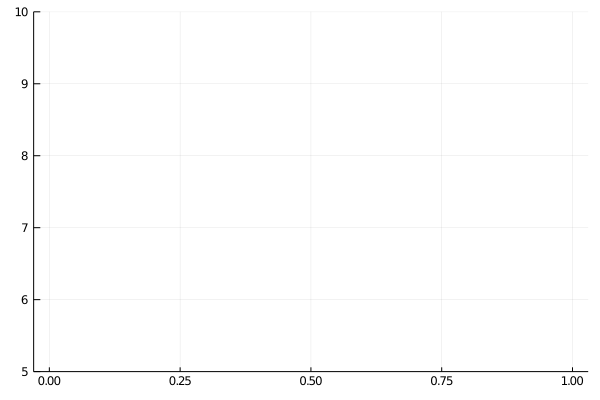

In [148]:
f(x) = ((x[1] - 1)^2 + 0.1 * (x[2] - 2^2)^2 + sin(5π * x[1])^4 + sin(5π * x[2])) * 0.12
x = [-1.8; 1.0]
d = -∇f(x)
ϕ(α) = f(x + α * d)
ϕd(α) = ForwardDiff.derivative(ϕ, α)
L(α) = ϕ(0) + ϕd(0) * α
arm(α) = ϕ(0) + 0.1 * ϕd(0) * α
plot(ϕ, 0, 1.0, leg=false)
plot!(L, 0, 1.0, c=:red, leg=false)
plot!(arm, 0, 1.0, c=:magenta, leg=false)
curv_α = []
for α = 0:0.001:1.0
    if ϕd(α) ≥ 0.9 * ϕd(0)
#     if abs(ϕd(α)) ≤ 0.9 * abs(ϕd(0))
        push!(curv_α, α)
    end
end
scatter!(curv_α, ϕ.(curv_α), m=(2,:green,stroke(0)))
ylims!(5, 10)

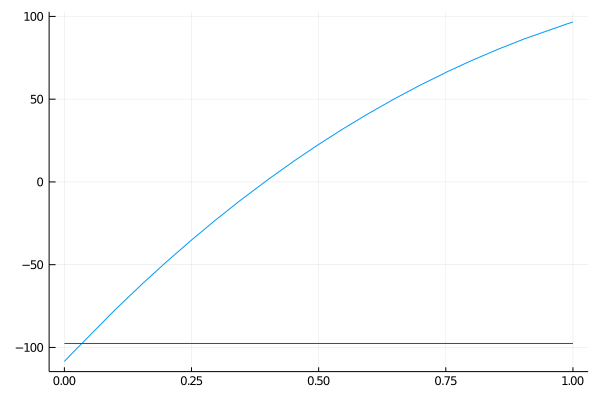

In [123]:
plot(ϕd, 0, 1, leg=false)
plot!(α -> 0.9 * ϕd(0), 0, 1, c=:green)